# Read in data
#### (I removed the two topcode variables as they are metadata, not data)
#### (I also removed euwgt and euhgt. They are not behavorial or socioeconomic factors)

In [142]:
import pandas as pd
from sklearn import tree
import graphviz

load = pd.read_excel('atus/ehresp_2014.xlsx')
column_names = ['eeincome1', 'erhhch', 'erincome', 'erspemch', 'ertpreat', 'ertseat', 'eudietsoda', 'eudrink', 'eueat', 'euexercise', 'euexfreq', 'eufastfd', 'eufastfdfrq', 'euffyday', 'eufdsit', 'eufinlwgt', 'eusnap', 'eugroshp', 'euinclvl', 'euincome2', 'eumeat', 'eumilk', 'euprpmel', 'eusoda', 'eustores', 'eustreason', 'eutherm', 'euwic', 'exincome1', 'eugenhth', 'erbmi']
target_column_name = 'erbmi'
dataset = load[column_names]
print(dataset.shape)
print(dataset[0:3])
dataset.dtypes

(11212, 31)
   eeincome1  erhhch  erincome  erspemch  ertpreat  ertseat  eudietsoda  \
0         -2       1        -1        -1        30        2          -1   
1          1       3         1        -1        45       14          -1   
2          2       3         5        -1        60        0          -1   

   eudrink  eueat  euexercise  ...  eumilk  euprpmel  eusoda  eustores  \
0        2      1           2  ...       2         1      -1         2   
1        2      1           2  ...       2         1      -1         1   
2        1      2           2  ...      -1         2       2        -1   

   eustreason  eutherm  euwic  exincome1  eugenhth      erbmi  
0           1        2      1          2         1  33.200001  
1           2        2      2          0         2  22.700001  
2          -1       -1      2         12         5  49.400002  

[3 rows x 31 columns]


eeincome1        int64
erhhch           int64
erincome         int64
erspemch         int64
ertpreat         int64
ertseat          int64
eudietsoda       int64
eudrink          int64
eueat            int64
euexercise       int64
euexfreq         int64
eufastfd         int64
eufastfdfrq      int64
euffyday         int64
eufdsit          int64
eufinlwgt      float64
eusnap           int64
eugroshp         int64
euinclvl         int64
euincome2        int64
eumeat           int64
eumilk           int64
euprpmel         int64
eusoda           int64
eustores         int64
eustreason       int64
eutherm          int64
euwic            int64
exincome1        int64
eugenhth         int64
erbmi          float64
dtype: object

## Replace all nonvalid value codes with 0 and remove all rows where the BMI or GenHealth data is missing.

In [95]:
df = dataset.applymap(lambda x: max(x,0))
empty_rows = list()
for i in range(df.shape[0]):
    if df.iloc[i]['erbmi'] == 0 or df.iloc[i]['eugenhth']==0:
        empty_rows.append(i)
df.drop(index=empty_rows, inplace=True)
df = df.reset_index(drop=True)
df.shape
df.loc[:4]

,eeincome1,erhhch,erincome,erspemch,ertpreat,ertseat,eudietsoda,eudrink,eueat,euexercise,...,eumilk,euprpmel,eusoda,eustores,eustreason,eutherm,euwic,exincome1,eugenhth,erbmi
0,0,1,0,0,30,2,0,2,1,2,...,2,1,0,2,1,2,1,2,1,33.200001
1,1,3,1,0,45,14,0,2,1,2,...,2,1,0,1,2,2,2,0,2,22.700001
2,2,3,5,0,60,0,0,1,2,2,...,0,2,2,0,0,0,2,12,5,49.400002
3,2,3,5,0,65,0,0,1,2,1,...,2,1,2,1,1,2,1,0,4,31.000000
4,1,3,1,1,20,10,1,1,1,1,...,0,2,1,0,0,0,2,0,3,30.700001


## create categorical columns bmi and genhth

In [124]:
def bmi_strlabel(x):
    if x == 0:
        return "Unreported"
    elif x < 18.5:
        return "Underweight"
    elif x < 25:
        return "Healthy"
    elif x < 30:
        return "Overweight"
    return "Obese"

def bmi_intlabel(x):
    if x == 0:
        return 0
    elif x < 18.5:
        return 1
    elif x < 25:
        return 2
    elif x < 30:
        return 3
    return 4

hthlabels= ["Unreported", "Excellent", "Very Good", "Good", "Fair","Poor"]

def hthlabel(x):
    if x == 0:
        return "Unreported"
    elif x == 1:
       return "Excellent"
    elif x == 2:
       return "Very Good"
    elif x == 3:
       return "Good"
    elif x == 4:
       return "Fair"
    else:
       return "Poor"

bmi_data = list()
hth_data = list()
for i in range(df.shape[0]):
    bmi_data.append(bmi_intlabel(df.iloc[i]['erbmi']))
    hth_data.append(hthlabel(df.iloc[i]['eugenhth']))

df_temp = pd.DataFrame({"genhth": hth_data})
df_temp = pd.DataFrame({"bmi": bmi_data, "genhth": hth_data})
df_temp["bmi"] = df_temp["bmi"].astype("category")
df_temp["genhth"] = df_temp["genhth"].astype("category")
data = pd.concat([df,df_temp],axis=1,sort=False)

In [143]:
data.dtypes

eeincome1         int64
erhhch            int64
erincome          int64
erspemch          int64
ertpreat          int64
ertseat           int64
eudietsoda        int64
eudrink           int64
eueat             int64
euexercise        int64
euexfreq          int64
eufastfd          int64
eufastfdfrq       int64
euffyday          int64
eufdsit           int64
eufinlwgt       float64
eusnap            int64
eugroshp          int64
euinclvl          int64
euincome2         int64
eumeat            int64
eumilk            int64
euprpmel          int64
eusoda            int64
eustores          int64
eustreason        int64
eutherm           int64
euwic             int64
exincome1         int64
eugenhth          int64
erbmi           float64
bmi            category
genhth         category
dtype: object

In [102]:
data.iloc[:4]

,eeincome1,erhhch,erincome,erspemch,ertpreat,ertseat,eudietsoda,eudrink,eueat,euexercise,...,eusoda,eustores,eustreason,eutherm,euwic,exincome1,eugenhth,erbmi,bmi,genhth
0,0,1,0,0,30,2,0,2,1,2,...,0,2,1,2,1,2,1,33.200001,Obese,Excellent
1,1,3,1,0,45,14,0,2,1,2,...,0,1,2,2,2,0,2,22.700001,Healthy,Very Good
2,2,3,5,0,60,0,0,1,2,2,...,2,0,0,0,2,12,5,49.400002,Obese,Poor
3,2,3,5,0,65,0,0,1,2,1,...,2,1,1,2,1,0,4,31.000000,Obese,Fair


# Train a Decision Tree Classifier using 'genhth' as the target

In [137]:
#data 
X_cols = list(data.columns)
#print(X_cols)
X_cols.remove('eugenhth')
X_cols.remove('genhth')
X_cols.remove('bmi')
X_cols.remove('eufinlwgt')
#X_cols.remove('erbmi')
X['erincome'] = X['erincome'].astype('category')
X = data.loc[:,X_cols]
X=X.dropna(how='any')
#X
y = data['genhth']
#y
classifier = tree.DecisionTreeClassifier(criterion='entropy',max_depth=3)
classifier.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

# Display a graph showing the nodes of the decision tree

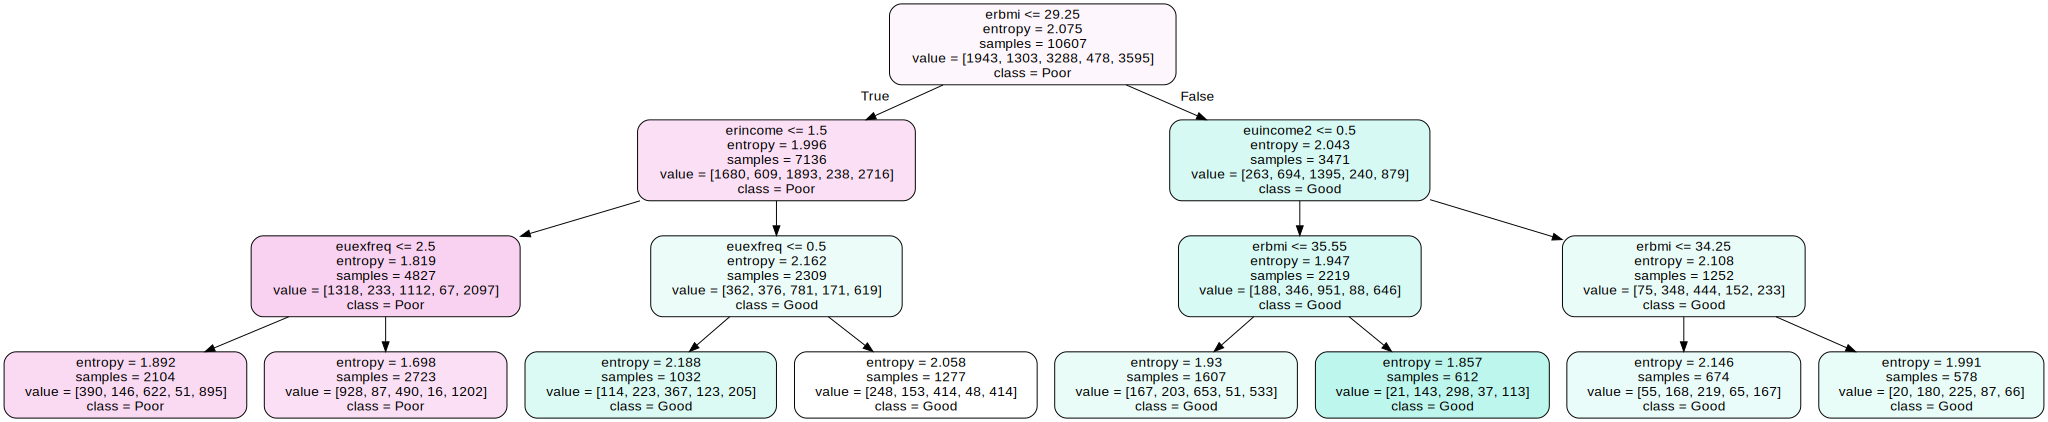

In [138]:
dot_data = tree.export_graphviz(classifier,feature_names=X.columns,class_names=hthlabels[1:],filled=True, rounded=True)
graph = graphviz.Source(dot_data)
#graph.render("BMI")
graph

### I think that the two income variables might make for too confusng confusing analysis. Lets just use one

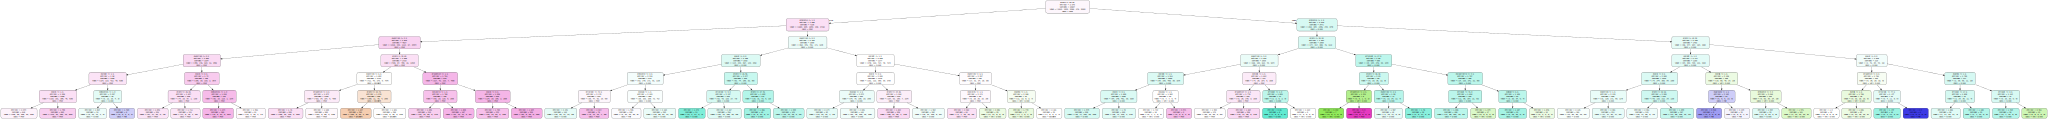

In [140]:
if 'euincome2' in X.columns:
    X = X.drop(columns=['euincome2'])
classifier = tree.DecisionTreeClassifier(criterion='entropy',max_depth=6)
classifier.fit(X,y)
dot_data = tree.export_graphviz(classifier,feature_names=X.columns,class_names=hthlabels[1:], filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph

# Now BMI is the major descriptor, followed by income and exercise